## Libraries

In [1]:
import os

In [2]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [3]:
import sys
sys.path.append('..')

In [4]:
from src.grass_functions import*
from src.process_inputs import*
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Parameters

In [5]:
#set project variables
Project_Area = 'LOB'
input_shp_name = pl.Path(os.getcwd()).parent/'data'/'Vectors'/Project_Area/f'HUC12_{Project_Area}.shp' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
in_tif = 'Clip_KYAPED_Digital_2.tif' #'Licking_DEM.tif'#,'BlueSinkingDEM','Clip_KYAPED_Digital_2']


GRASS_GIS_Projection = projection = '3089' #set to None if you want to use the DEM's original projection
res = '2ft'
## Set variables analysis
data_scale = 'huc12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '*' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
streams_shp = pl.Path(os.getcwd()).parent/'data'/'Vectors'/Project_Area/'scopelines.shp'
buffer = 500 #untis of projection
auto_delete = False
dem = 'project_dem'
aligned = False
align_rast = dem #set to False if no realignment needed

In [8]:
if data_scale.find('HUC') >= 0:
    huc_level = re.findall("[0-9]+",data_scale)[0]
    if huc_level == str(len(select_data)):
        huc_digys = huc_level
    else:
        huc_digys = huc_level
        select_data = select_data[:int(huc_digys)]

In [9]:
## Paths:
parent_dir = pl.Path(os.getcwd()).parent/'data'
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
huc_path = vector_dir/'{}_aoi.geojson'.format(Project_Area)
git_data_repo = current_dir/'data_repository'
if input_shp_name:
    input_shp = vector_dir/input_shp_name
directory = outputs_dir

### Get area of interest

In [10]:
#prep work
if data_scale.find('HUC') >= 0:
    wbd = nhd_download(select_data,vector_dir)

    #read in HUC12s vector file from NHD
    local_huc4 = gpd.read_file(vector_dir/wbd, layer='WBDHU{}'.format(huc_digys))

    #reformat fields to handle disparate USGS data formats
    local_huc4 = lower_pd_cols(local_huc4.copy())
    if to_headwaters:
        ## function to get most downstream HUC12 if HUC10 or HUC8 is entered
        select_data = get_downstream_huc12(select_data,local_huc4)

        #get all upstream HUC12s
        local_huc12 = local_huc4.loc[local_huc4['huc12'] == select_data]
        upstream_list = get_upstream_extent_usgs(select_data) #selected huc12
        aoi = local_huc4.loc[local_huc4['huc12'].isin(upstream_list) == True]
    else:
        aoi = local_huc4.loc[local_huc4['huc{}'.format(huc_digys)] == select_data]
        local_huc12 = None
else:
    aoi = gpd.read_file(input_shp)
    local_huc12 = None
#save to vector for later analysis
huc_path = vector_dir/'{0}_aoi.geojson'.format(Project_Area)
#fix topological errors
aoi['geometry'] = aoi.buffer(0) 
aoi.to_crs(epsg=projection).to_file(str(huc_path),driver="GeoJSON")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [11]:
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")

### Create new drainpoint shpfile

In [12]:
from shapely import Point
def get_first_point_on_line(streams: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    '''
    Parameters:
    -----------
      streams: gdf of streams (as linestring shapely geometry)
    Return:
    --------
       nodes: gdf of the first point along each stream, provided that streams drawn in upstream to downstream so first point represents most upstream point along line.
    '''
    nodes = streams.copy().explode()
    nodes['node_geo'] = nodes['geometry'].apply(lambda x: Point(x.coords[0]))
    nodes = nodes.set_geometry('node_geo')
    nodes = nodes.drop('geometry',axis=1)
    return nodes

In [13]:
streams = gpd.read_file(str(streams_shp))
streams['OBJECTID'] = streams.index
stream_points = get_first_point_on_line(streams)

In [14]:
stream_points.to_file(str(streams_shp).replace('.shp','_points.shp'))

### Start new grass session

In [15]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [16]:
raster_dir

PosixPath('/home/data/Rasters/LOB')

In [17]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)
#initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'LOB_3089', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [27]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
aoi@PERMANENT

Available raster maps:


In [22]:
#remove old files if needed
remove_grass_data(grass_maps,'None','raster') #update 'None' with map name ('None' or 'all' or could be the name of the file e.g. 'aoi') and type (i.e. 'raster' or 'vector' )

### Get Raster data

In [28]:
if 'dem2@PERMANENT' not in grass_maps['raster']:
    if 'project_dem@PERMANENT' not in grass_maps['raster']:
        gs.run_command('r.in.gdal', input=raster_dir/in_tif, output= dem)

Importing raster map <project_dem>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


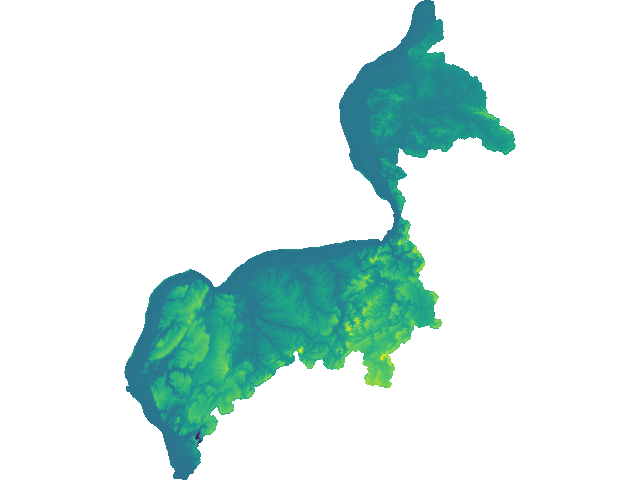

In [29]:
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
Image(filename="map.png")

In [20]:
#### If the Null values in the plot above are colored in, then uncomment this cell and run it 

# if 'dem2@PERMANENT' not in grass_maps['raster']:
#     gs.run_command('r.mapcalc', expression="dem2 = if(project_dem > 0, project_dem, null())")
# dem = 'dem2'

## Align to specific grid (optional)

In [30]:
if aligned:
    #export realigned DEM
    gs.run_command('g.region',raster = dem, align = align_rast)
    gs.run_command('r.resamp.interp',input=dem, output=dem+'_a',method='bilinear')
    dem = dem+'_a'
    gs.parse_command('r.info',map=dem, flags='g')
    gs.run_command('r.out.gdal', input= dem, output= raster_dir/f'{dem}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')
else:
    ##print basins in grass @ Regional scale to confirm data and extent
    gs.run_command('g.region',raster = dem, align = dem)

In [31]:
#add project area
basins = 'aoi'
gs.run_command('v.import', input= huc_path,  output= basins,overwrite='True')

Check if OGR layer <LOB_aoi> contains polygons...
   0   2   4   6   8  11  13  15  17  20  22  24  26  28  31  33  35  37  40  42  44  46  48  51  53  55  57  60  62  64  66  68  71  73  75  77  80  82  84  86  88  91  93  95  97 100
Creating attribute table for layer <LOB_aoi>...
Importing 45 features (OGR layer <LOB_aoi>)...
   0   2   4   6   8  11  13  15  17  20  22  24  26  28  31  33  35  37  40  42  44  46  48  51  53  55  57  60  62  64  66  68  71  73  75  77  80  82  84  86  88  91  93  95  97 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
   2   4   6   8  11  13  15  17  20  22  24  26  28  31  33  35  37  40  42  44  46  48  51  53  55  57  60  62  64  66  68  71  73  75  77  80  82  84  86  88  91  93  95  97 100
Breaking polygons (pass 2:

0

In [32]:
gs.run_command('v.import', input= str(streams_shp).replace('.shp','_points.shp'),output='start_points',overwrite=True)

Check if OGR layer <scopelines_points> contains polygons...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Creating attribute table for layer <scopelines_points>...
Importing 124 features (OGR layer <scopelines_points>)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
-----------------------------------------------------
Building topology for vector map <start_points@PERMANENT>...
Registering primitives...
Input </home/data/Vectors/LOB/scopelines_points.shp> successfully imported
without reprojection


0

In [ ]:
# CONFIRM DEM boundaries and star points are all overlapping one another, it's fine if it's in a HUC but doesn't overlap the DEM

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.
d.vect complete.


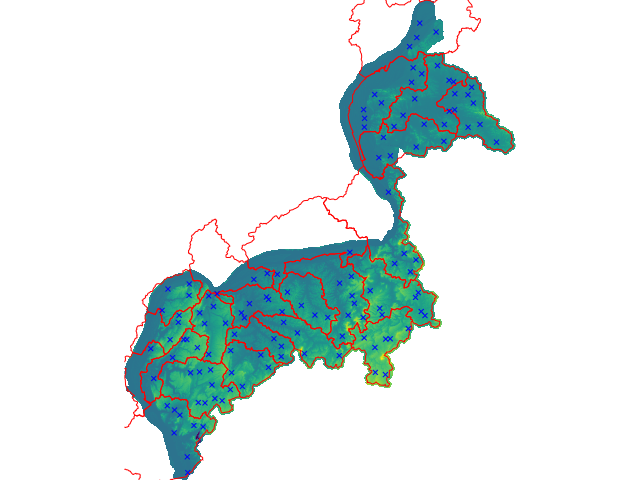

In [33]:
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= 'aoi',color='red',fill_color='None')
gs.run_command('d.vect', map= 'start_points',color='blue',fill_color='None')
#gs.run_command('d.vect', map= 'start_points_local',color='blue',fill_color='None')
#gs.run_command('d.vect', map= 'tmp_addtl_points',color='green',fill_color='None')
Image(filename="map.png")

# confirm cell sizes

In [35]:
# this to confirm resolution is indeed 2ft by 2ft, and that is the nsres and ewres
gs.parse_command('r.info',map=dem, flags='g')

{'north': '3824489.40631774',
 'south': '3585600.37807519',
 'east': '4310404.98683999',
 'west': '4115682.29437465',
 'nsres': '1.99999186439408',
 'ewres': '1.99998657038003',
 'rows': '119445',
 'cols': '97362',
 'cells': '11629404090',
 'datatype': 'FCELL',
 'ncats': '0'}

In [36]:
if aligned:
    gs.parse_command('r.info',map=align_rast, flags='g')

## Loop through basins and run drain patterns

In [41]:
areas = aoi['huc12'].to_list()

In [ ]:
# nothing here needs to change
stream_rasts = []
for area in areas:
    if not os.path.exists(vector_dir/f'streams_out_v_{area}.shp'):
        gs.run_command('g.region',raster = dem, align = dem)
        tmp = aoi.loc[aoi['huc12'] == area].buffer(buffer).to_file(vector_dir/'tmp.shp')
        gs.run_command('v.import', input= vector_dir/'tmp.shp',  output= f'{basins}_{area}')
        gs.run_command('r.mask',vector=f'{basins}_{area}')
        gs.run_command('g.region',vector = f'{basins}_{area}', align = dem)
        ###add in extra points
        gs.run_command('v.select',ainput='start_points',binput=f'{basins}_{area}',output='start_points_local',operator='intersects')
        basin_s = aoi.loc[aoi['huc12'] == area].to_crs(streams.crs)
        clipped_streams = gpd.clip(streams,basin_s.geometry)
        stream_ids = clipped_streams.OBJECTID.to_list()
        stream_points_clipped = get_first_point_on_line(clipped_streams)
        #ignore points already in 
        streams_in_play = list(gs.parse_command('v.db.select',map='start_points_local',columns='OBJECTID',flags='c').keys())
        loc = []
        for addtl_point  in stream_ids:
            if str(addtl_point) not in streams_in_play:
                loc.append(addtl_point)
        if not stream_points_clipped.loc[stream_points_clipped['OBJECTID'].isin(loc) == True].empty:
            stream_points_clipped.loc[stream_points_clipped['OBJECTID'].isin(loc) == True].to_file(str(streams_shp).replace('.shp','_points_tmp.shp'))
            gs.run_command('v.import', input= str(streams_shp).replace('.shp','_points_tmp.shp'),  output= f'tmp_addtl_points')
            gs.run_command('v.out.ascii', input= 'tmp_addtl_points',output='tmp.csv',format='standard')
            gs.run_command('v.edit', map= 'start_points_local',tool='add',input='tmp.csv')
        ###
        gs.run_command('r.watershed', flags='sb', elevation=dem, drainage='drain_dir',memory='110000')
        gs.run_command('r.mapcalc', expression="drain_deg = if(drain_dir != 0, 45. * abs(drain_dir), null())")
        gs.run_command('r.mapcalc', expression="const1 = 1")
        gs.run_command('r.drain',flags='d', input='const1', direction='drain_deg', output=f'streams_out_{area}', drain=f'streams_out_v_{area}', start_points='start_points_local')
        stream_rasts.append(f'streams_out_{area}')
        gs.run_command('v.out.ogr',flags='e', input=f'streams_out_v_{area}', output=vector_dir/f'streams_out_v_{area}.shp', format='ESRI_Shapefile')
        gs.run_command('r.mask',flags='r')             

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
Check if OGR layer <tmp> contains polygons...
   0 100
Creating attribute table for layer <tmp>...
Importing 1 features (OGR layer <tmp>)...
   0 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Breaking boundaries...
   0 100
-----------------------------------------------------
Removing duplicates...
 100
---------------------

In [26]:
# if this fails you might want to remove the mask with this line
gs.run_command('r.mask',flags='r')

ERROR: No existing MASK to remove


CalledModuleError: Module run None r.mask -r ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

## END